In [ ]:
"""
Created on July, 2024

@author: Weronika Golletz
@author: Czcibor Ciostek

Womanium Quantum + AI Project
"""

# 1D transverse-field Ising model

n this notebook, we analyze the one-dimensional (1D) transverse-field Ising model with $N=4$ spins without periodic boundary conditions. We focus on how the global magnetization changes over time. To simulate the system's dynamics, we use the Classiq Python SDK.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  pfb2t1c2pfb poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  tex-common tex-gyre texlive-base texlive-binaries texlive-fonts-recommended
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-fram

In [ ]:
!pip install -U classiq

In [ ]:
#classiq.authenticate()

In [ ]:
from classiq import *
from classiq.execution import ExecutionPreferences
from classiq.execution import ExecutionSession

In [3]:
# Plots settings
WIDTH = 5
HEIGHT = 3

SMALLER_SIZE = 11
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALLER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcParams['text.usetex'] = True
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [ ]:
# Parameters of the Suzuki-Trotter decomposition
REPETITIONS = 1000

In [ ]:
def get_repetitions():
  """
  Just returns the global variable repetitions;
  allows us to control the 'repetitions' parameter
  as a funciton variable.
  """
  return REPETITIONS

def mz_state(basis):
    """
    Calculate the magnetization of a given state in the basis.

    Input
    -----
    basis (str): a state from the basis
    N (int): number of spins

    Output
    ------
    mz (int): magnetization of a given state
    """
    mz = 0
    for id in range(len(basis)):
        mz += (1-2*int(basis[id]))
    return mz

def mz_total(basis,state):
    """
    Calculate the total magnetization for a given state.

    Input
    -----
    basis (str): computational basis for N=4 spins
    state (np.array): the state in which the magnetization is calculated
    N (int): number of spins

    Output
    ------
    (float): the total magnetization of a system
    """
    mz_total = 0
    for jd in range(len(basis)):
        mz_total += state[jd] * mz_state(basis[jd])
    return mz_total/N

In [ ]:
# Defining the Hamiltonian
def get_hamiltonian(J,h):
  """
  Generate the Ising Hamiltonian for N=4 spins without periodic boundary conditions.

  Input
  -----
  J (float): interaction strength
  h (float): transverse field strength

  Output
  ------
  hamiltonian (np.array): Hamiltonian for N=4 spins
  """
  hamiltonian = [
        PauliTerm([Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], J),
        PauliTerm([Pauli.I, Pauli.Z, Pauli.Z, Pauli.I], J),
        PauliTerm([Pauli.I, Pauli.I, Pauli.Z, Pauli.Z], J),
        PauliTerm([Pauli.X, Pauli.I, Pauli.I, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.X, Pauli.I, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.I, Pauli.X, Pauli.I], h),
        PauliTerm([Pauli.I, Pauli.I, Pauli.I, Pauli.X], h),
        ]
  return hamiltonian

In [ ]:
@qfunc
def main(time:CReal,J:CReal,h:CReal,qreg: Output[QArray]):
    # Parameters of the system
    N = 4

    # Parameters of the system's dynamics
    REPETITIONS = get_repetitions()
    order = 1

    # Create a qcircuit
    allocate(N,qreg) # initial state |0,0,0,0>

    suzuki_trotter(
        get_hamiltonian(J,h),
        evolution_coefficient=time,
        repetitions=REPETITIONS,
        order=order,
        qbv=qreg,
    )

In [ ]:
# Parameters of the system
N = 4           # Number of spins
J = 1.0         # Interaction strength
h = -3.0        # Transverse field strength

### Different times and repetitions; shots=1000

In [ ]:
times = np.arange(0.0,3,0.05)
repetitions_list = [5,10,15,20,100]

magnetizations_cl_rep = np.zeros((len(repetitions_list),len(times)))

# Parameters related to qcircuit and measurement
shots = 1000

for (jd,REPETITIONS) in enumerate(repetitions_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program,
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time,"J":-1,"h":-3})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_rep[jd,id] = mz_total(basis,state)

In [ ]:
magnetizations_cl_rep

array([[ 1.    ,  0.9535,  0.824 ,  0.6225,  0.3695,  0.093 , -0.188 ,
        -0.4355, -0.623 , -0.7465, -0.824 , -0.808 , -0.717 , -0.588 ,
        -0.432 , -0.217 , -0.0415,  0.1535,  0.285 ,  0.382 ,  0.4295,
         0.425 ,  0.385 ,  0.302 ,  0.202 ,  0.105 , -0.0085, -0.116 ,
        -0.159 , -0.1815, -0.188 , -0.17  , -0.126 , -0.067 , -0.0215,
         0.0235,  0.0455,  0.0545,  0.0315, -0.0235, -0.094 , -0.19  ,
        -0.324 , -0.452 , -0.5785, -0.687 , -0.7815, -0.8745, -0.9305,
        -0.965 , -0.984 , -0.9955, -0.9995, -0.9985, -0.996 , -0.9905,
        -0.9805, -0.9735, -0.9475, -0.923 ],
       [ 1.    ,  0.9535,  0.8245,  0.6225,  0.37  ,  0.0935, -0.1855,
        -0.433 , -0.624 , -0.7465, -0.824 , -0.8105, -0.726 , -0.592 ,
        -0.44  , -0.242 , -0.064 ,  0.135 ,  0.255 ,  0.3645,  0.416 ,
         0.4335,  0.406 ,  0.333 ,  0.26  ,  0.177 ,  0.0715, -0.0245,
        -0.102 , -0.1355, -0.1595, -0.1715, -0.16  , -0.1455, -0.127 ,
        -0.1035, -0.0745, -0.059

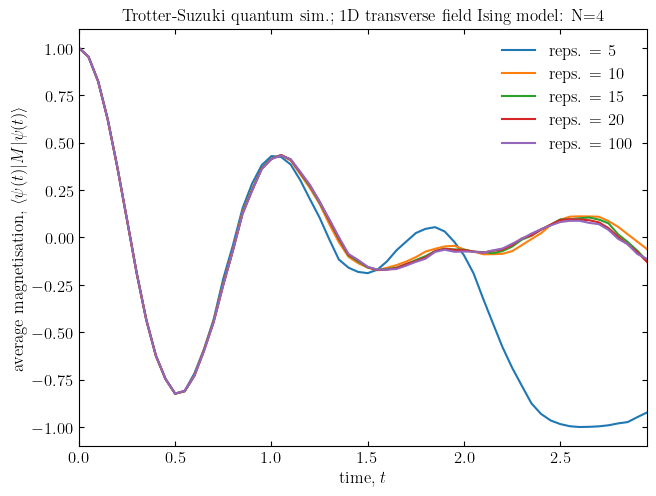

In [5]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(repetitions_list)):
  ax.plot(times,magnetizations_cl_rep[id,:],label=f"reps. = {repetitions_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title("Trotter-Suzuki quantum sim.; 1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

### Different times and shots; repetitions=15

In [ ]:
times = np.arange(0.0,3,0.05)
shots_list = [500,1000,2000,5000,10000]

magnetizations_cl_shots = np.zeros((len(shots_list),len(times)))

# Parameters related to qcircuit and measurement
REPETITIONS = 15

for (jd,shots) in enumerate(shots_list):
  qcircuit = create_model(main)
  quantum_program = synthesize(qcircuit)

  # ExecuteSession for symbolic parameters
  exe_session = ExecutionSession(quantum_program,
                                  ExecutionPreferences(
                                  num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                                ))
  # show(quantum_program)

  for (id,time) in enumerate(times):
    results = exe_session.sample({"time":time,"J":-1,"h":-3})

    # calculate magnetization
    data = results.counts
    state = [v/shots for v in data.values()]
    basis = list(data.keys())
    magnetizations_cl_shots[jd,id] = mz_total(basis,state)

In [ ]:
magnetizations_cl_shots

array([[ 1.     ,  0.954  ,  0.824  ,  0.617  ,  0.364  ,  0.076  ,
        -0.192  , -0.444  , -0.638  , -0.764  , -0.833  , -0.823  ,
        -0.742  , -0.611  , -0.461  , -0.251  , -0.084  ,  0.129  ,
         0.243  ,  0.352  ,  0.403  ,  0.418  ,  0.407  ,  0.319  ,
         0.247  ,  0.167  ,  0.082  , -0.024  , -0.107  , -0.136  ,
        -0.169  , -0.184  , -0.172  , -0.174  , -0.157  , -0.135  ,
        -0.111  , -0.09   , -0.068  , -0.083  , -0.082  , -0.085  ,
        -0.091  , -0.092  , -0.09   , -0.07   , -0.025  ,  0.001  ,
         0.027  ,  0.051  ,  0.085  ,  0.083  ,  0.091  ,  0.1    ,
         0.082  ,  0.069  ,  0.008  , -0.025  , -0.076  , -0.144  ],
       [ 1.     ,  0.9535 ,  0.8245 ,  0.6225 ,  0.3705 ,  0.0945 ,
        -0.1855 , -0.432  , -0.623  , -0.746  , -0.8235 , -0.8115 ,
        -0.7285 , -0.594  , -0.4415 , -0.2465 , -0.069  ,  0.1295 ,
         0.251  ,  0.3645 ,  0.415  ,  0.4345 ,  0.4115 ,  0.341  ,
         0.27   ,  0.184  ,  0.0905 , -0.008  ,

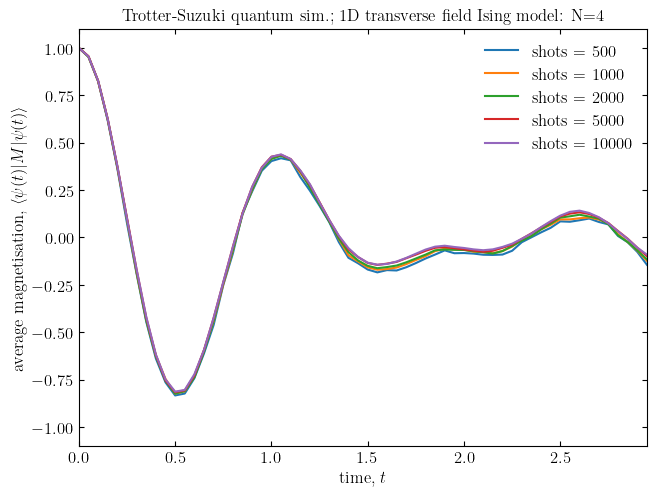

In [7]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
fig, ax = plt.subplots()
for id in range(len(shots_list)):
  ax.plot(times,magnetizations_cl_shots[id,:],label=f"shots = {shots_list[id]}") #, marker='x',color='red',markersize=5)

# ax_inset = fig.add_axes([0.4, 0.7, 0.27, 0.27])  # [left, bottom, width, height]
# for id in range(len(repetitions_list)):
#   ax_inset.plot(times[3:],magnetizations_cl_rep[id,3:])
# ax_inset.set_ylim(-0.25,0.1)
# ax_inset.tick_params(direction='in')
# ax_inset.tick_params(top=True, right=True, which='major')


ax.set_xlim(0,times[-1])
ax.set_ylim(-1.1,1.1)
ax.tick_params(direction='in')
ax.tick_params(top=True, right=True, which='major')
ax.legend(frameon=False)
ax.set_xlabel(r'time, $t$')
ax.set_ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
ax.set_title("Trotter-Suzuki quantum sim.; 1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()

### Different times; repetitions=15, shots=1000 (final results)

In [ ]:
times = np.arange(0.0,3.,0.05)

magnetizations_cl = np.zeros(len(times))

# Parameters related to qcircuit and measurement
REPETITIONS = 15
shots = 1000

qcircuit = create_model(main)
quantum_program = synthesize(qcircuit)

# ExecuteSession for symbolic parameters
exe_session = ExecutionSession(quantum_program,
                                ExecutionPreferences(
                                num_shots=shots, job_name=f"suzuki-trotter", random_seed=767
                              ))
# show(quantum_program)

for (id,time) in enumerate(times):
  results = exe_session.sample({"time":time,"J":-1,"h":-3})

  # calculate magnetization
  data = results.counts
  state = [v/shots for v in data.values()]
  basis = list(data.keys())
  magnetizations_cl[id] = mz_total(basis,state)

In [ ]:
magnetizations_cl

array([ 1.    ,  0.9535,  0.8245,  0.6225,  0.3705,  0.0945, -0.1855,
       -0.432 , -0.623 , -0.746 , -0.8235, -0.8115, -0.7285, -0.594 ,
       -0.4415, -0.2465, -0.069 ,  0.1295,  0.251 ,  0.3645,  0.415 ,
        0.4345,  0.4115,  0.341 ,  0.27  ,  0.184 ,  0.0905, -0.008 ,
       -0.0935, -0.1265, -0.1575, -0.17  , -0.1665, -0.1585, -0.1405,
       -0.119 , -0.0985, -0.072 , -0.059 , -0.063 , -0.0645, -0.075 ,
       -0.077 , -0.083 , -0.0715, -0.048 , -0.0115,  0.009 ,  0.0425,
        0.067 ,  0.0955,  0.0955,  0.1015,  0.1055,  0.0945,  0.075 ,
        0.017 , -0.0235, -0.0695, -0.123 ])

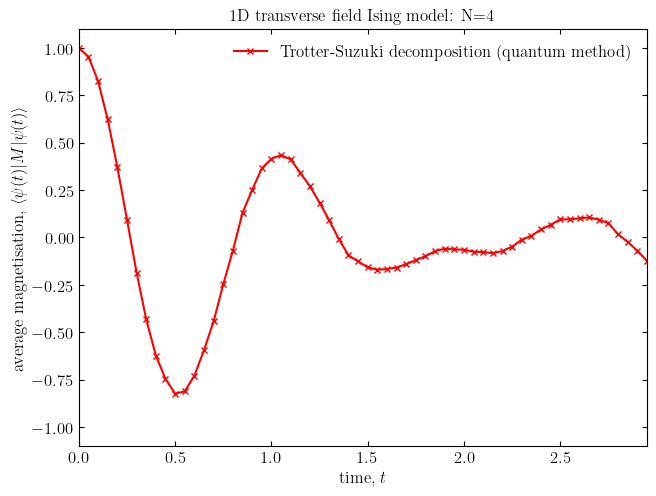

In [9]:
# plot
# plt.plot(times,magnetizations_exact,label=f"Exact evolution")
# plt.plot(t_maxs,magnetizations_TS,label=f"Trotter-Suzuki decomposition (without Classiq)", lw=0, marker='o',color='k',markersize=5)
plt.plot(times,magnetizations_cl,label=f"Trotter-Suzuki decomposition (quantum method)", marker='x',color='red',markersize=5)
plt.xlim(0,times[-1])
plt.ylim(-1.1,1.1)
plt.tick_params(direction='in')
plt.tick_params(top=True, right=True, which='major')
plt.legend(frameon=False)
plt.xlabel(r'time, $t$')
plt.ylabel(r"average magnetisation, $\langle \psi(t)| M | \psi(t) \rangle$")
plt.title("1D transverse field Ising model: N=4")
plt.tight_layout(pad=0.1, w_pad=0.4, h_pad=0.5)
# plt.savefig("name.png",dpi=300)
# plt.savefig("name.svg")
plt.show()